# My TTN library
In this notebook I try to develop my personal library to handle TTNs, their definition, properties, automatic contraction and training.

In [1]:
import torch
import numpy as np
from typing import Sequence, List, Tuple, ValuesView
import graphviz
graphviz.set_jupyter_format('png')
from matplotlib import colormaps, colors
import matplotlib.pyplot as plt
import colorsys
from tqdm import tqdm, trange
from string import ascii_letters
from timeit import timeit
from datetime import datetime
from algebra import contract_up, sep_partial_dm, kron
from utils import adjust_lightness, get_mnist_data_loaders, accuracy, get_stripeimage_data_loaders, get_iris_data_loaders
from torchinfo import summary

/media/alberto/Volume/Kubuntu/PoD/Thesis/TN4HEP/TTN/algebra.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Automatic contractions
Try to develop methods to do automatic contractions, also based on the network structure (separability of states)
### Network description

In [2]:
from __future__ import annotations
from collections import UserString

class TIndex:
    def __init__(self, name, inds: Sequence[str] | np.ndarray):
        self.__name = name
        self.__tindices = np.array(inds, dtype=np.str_) # problems with string lenghts
        self.__ndims = len(inds)
    
    def __getitem__(self, key: int) -> str:
        return self.__tindices[key]
    
    def __setitem__(self, key: int, value: str):
        old_len = self.__tindices.dtype.itemsize / 4
        new_len = max(old_len, len(value))
        self.__tindices = self.__tindices.astype(f"<U{new_len:.0f}")
        self.__tindices[key] = value
    
    @property
    def name(self):
        return self.__name 

    @property
    def indices(self):
        return self.__tindices
    
    @property
    def ndims(self):
        return self.__ndims
    
    ''' I do not want them to be changed by design   
    @indices.setter
    def indices(self, value: Sequence[str]):
        self.__indices = value
    '''
    
    def __eq__(self, __value: TIndex | str) -> bool:
        if isinstance(__value, str):
            return self.__name == __value
        return self.__name == __value.name and np.all(self.__tindices == __value.indices)
    
    def __gt__(self, __value: TIndex | str) -> bool:
        compare = __value if isinstance(__value, str) else __value.name
        try:    compare_layer = int(compare.split('.')[0])
        except: compare_layer = np.inf
        try:    self_layer = int(self.__name.split('.')[0])
        except: self_layer = np.inf

        if self_layer > compare_layer:
            return True
        elif self_layer == compare_layer:
            return int(self.__name.split('.')[1]) > int(compare.split('.')[1])
        return False
    
    def __lt__(self, __value: TIndex | str) -> bool:
        compare = __value if isinstance(__value, str) else __value.name
        try:    compare_layer = int(compare.split('.')[0])
        except: compare_layer = np.inf
        try:    self_layer = int(self.__name.split('.')[0])
        except: self_layer = np.inf

        if self_layer < compare_layer:
            return True
        elif self_layer == compare_layer:
            return int(self.__name.split('.')[1]) < int(compare.split('.')[1])
        return False
    
    def __ge__(self, __value: TIndex | str) -> bool:
        return self.__gt__(__value) or self.__eq__(__value)
    
    def __le__(self, __value: TIndex | str) -> bool:
        return self.__lt__(__value) or self.__eq__(__value)
    
    def __hash__(self):
        return hash(self.__name)
    
    def __str__(self) -> str:
        return self.__name
    
    def __repr__(self) -> str:
        return 'TIndex: ' + self.__name
    
    def _repr_markdown_(self):
        return f'**{self.__repr__()}**'
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#0088d9; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for index in self.__tindices:
            markdown_str += f'&emsp;&ensp; <b style="color:#be00d9">{index}</b><br>'
        return markdown_str + '</details>'
    
class TTNIndex(TIndex):
    def __init__(self, layer: int, layer_index: int):

        self.__layer = layer
        self.__layer_index = layer_index
        super(TTNIndex, self).__init__(f"{layer}.{layer_index}",
                                       [f"{layer+1}.{2*layer_index}", f"{layer+1}.{2*layer_index+1}", f"{layer}.{layer_index}"], 
                                       )
    
    def __repr__(self) -> str:
        return f"TTNIndex: {self.__layer}.{self.__layer_index}"
    
# class which represent the link between two tensors in the TTN
class TLink:
    def __init__(self, source: TIndex, target: TIndex, dim: int, dependencies: List[TIndex] = [], name: str = None):
        self.__source = source
        self.__target = target
        self.__dim = dim
        self.__vector = None
        self.__has_updated_vector = False
        self.__name = name if name is not None else f"{source.name}"
        self.__dependencies = dependencies

    @property
    def source(self):
        return self.__source
    
    @property
    def target(self):
        return self.__target
    
    @property
    def name(self):
        return self.__name
    
    @property
    def vector(self):
        if self.__has_updated_vector:
            return self.__vector
        elif self.__vector is not None:
            raise ValueError(f"No vector is set for TLink {self.__name}.")
        else:
            raise ValueError(f"TLink {self.__name} vector is not updated.")
        
    @vector.setter
    def vector(self, value):
        self.__vector = value
        self.__has_updated_vector = True

    @property
    def is_updated(self):
        return self.__has_updated_vector
    
    def depends_on(self, __value: TIndex | str) -> bool:
        return __value in self.__dependencies

    


In [3]:
def one_epoch_one_tensor_torch(tensor, data_batched, train_dl, optimizer, loss_fn, device='cuda', pbar=None, disable_pbar=False):
    # perform one epoch of optimization of a single tensor
    # given the data_tn and the optimizer
    tot_data = 0
    lossess = []
    if pbar is None:
        pbar = tqdm(data_batched, total=len(data_batched),position=0, disable=disable_pbar)
    with torch.autograd.set_detect_anomaly(True):
        for data, batch in zip(data_batched, train_dl):
            optimizer.zero_grad()
            labels = batch[1].to(device=device)
            
            outputs = contract_up(tensor, data.unbind(1))
            
            probs = torch.real(torch.pow(outputs, 2))
            probs = probs / torch.sum(probs)
            loss = loss_fn(labels, probs)

            loss.backward()
            optimizer.step()
            lossess.append(loss.cpu())
            tot_data += labels.shape[0]
            pbar.update()
            pbar.set_postfix_str(f'loss: {loss.item():.3f}')
    
    pbar.set_postfix({'loss': loss.item(), 'epoch mean loss': np.array([loss.item() for loss in lossess]).mean()})
    pbar.close()
    return lossess

#### Reimplement initialization

In [4]:
def sep_partial_dm_torch(
    keep_index,
    sep_states: torch.utils.data.DataLoader | torch.Tensor, # TODO: support also list of tensors with eventually different shapes
    skip_norm=False,
    device="cpu",
):
    if not isinstance(keep_index, torch.Tensor):
        keep_index = torch.tensor(keep_index, device=device, dtype=torch.int64)
    if isinstance(sep_states, torch.utils.data.DataLoader):
        discard_index = torch.ones(
            next(iter(sep_states))[0].shape[-2], dtype=torch.bool
        )
        discard_index[keep_index] = False
        rho_list = []
        for batch in tqdm(sep_states, desc="sep_partial_dm", position=1):
            batch = batch[0].to(device)
            if skip_norm:
                norm_factor = torch.eye(1, device=device)
            else:
                norm_factor = torch.prod(
                    torch.sum(batch[..., discard_index, :] ** 2, dim=-1), dim=-1
                ).squeeze()

            rhos = torch.einsum(
                "...i,...j->...ij",
                batch[..., keep_index, :].conj(),
                batch[..., keep_index, :],
            )
            rho = torch.eye(1, device=device, dtype=torch.complex128)

            for i in (
                keep_index - keep_index.min()
            ):  # strange way to index but in this way we can get the partial density matrix also for different permutations of the sites
                rho = kron(rho, rhos[..., i, :, :], batchs=batch.shape[0])

            rho_list.append(
                rho * norm_factor.view([-1] + [1] * (rho.ndim - norm_factor.ndim))
            )
        return torch.concat(rho_list, dim=0)
    
    elif isinstance(sep_states, torch.Tensor):
        # sep_states is a tensor of separable states with shape B x N x d 
        # (B is optional batch dimension, N is number of sites, d is local dimension)
        batch = sep_states.to(device)
        if skip_norm:
            norm_factor = torch.eye(1, device=device, dtype=sep_states.dtype)
        else:
            discard_index = torch.ones(sep_states.shape[-2], dtype=torch.bool)
            discard_index[keep_index] = False
            norm_factor = torch.prod(
                torch.sum(batch[..., discard_index, :] ** 2, dim=-1), dim=-1
            ).squeeze()

        # get rhos of single sites
        rhos = torch.einsum(
            "...i,...j->...ij",
            batch[..., keep_index, :].conj(),
            batch[..., keep_index, :],
        )
        rho = torch.eye(1, device=device)

        # tensor product of rhos of single sites if they are selected
        for i in keep_index - keep_index.min():
            rho = kron(rho, rhos[..., i, :, :], batchs=batch.shape[0])

        return rho * norm_factor.view([-1] + [1] * (rho.ndim - norm_factor.ndim))
    
    else:
        raise TypeError(
            f"sep_states must be one of torch.utils.data.DataLoader, torch.Tensor or quimb.tensor.TensorNetwork, got: {type(sep_states)}"
        )


#### TTN class

In [5]:
class TTN:
    def __init__(
        self,
        n_features,
        n_phys=2,
        n_labels=2,
        label_tag="label",
        bond_dim=4,
        dtype=torch.cdouble,
        device="cpu",
    ):
        if (n_features % 2) != 0:
            raise ValueError(f"n_features must be  power of 2, got: {n_features}")

        self.n_features = n_features
        self.n_phys     = n_phys
        self.n_labels   = n_labels
        self.label_tag  = label_tag
        self.bond_dim   = bond_dim
        self.device     = device

        self.__dtype    = dtype
        self.__n_layers = int(np.log2(n_features))
        self.__tensors  = []
        self.__indices  = [TTNIndex(l, i) for l in range(self.__n_layers) for i in range(2**l)]
        # label top edge as label
        self.__indices[0][2] = label_tag
        # label bottom edges as data
        for ttnindex in self.__indices[-2**(self.__n_layers-1):]:
            ttnindex[0] = f'data.{ttnindex[0].split(".")[1]}'
            ttnindex[1] = f'data.{ttnindex[1].split(".")[1]}'
        # convert to numpy array for easier indexing
        self.__indices = np.asarray(self.__indices)

        self.__initialized = False

        ## INITIALIZE TENSORS ##
        # add first tensor with special index
        if not (self.__n_layers - 1):
            self.__tensors.append(
                torch.rand(
                    size=(self.n_phys, self.n_phys, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )
        else:
            dim = min(self.n_phys**2**(self.__n_layers-1), self.bond_dim)
            self.__tensors.append(
                torch.rand(
                    size=(dim, dim, self.n_labels),
                    dtype=self.__dtype,
                    device=self.device
                )
            )

        for l in range(1, self.__n_layers - 1):  # constructing the ttn starting from the top
            dim_pre = min(self.n_phys**2**(self.__n_layers - l - 1), self.bond_dim)
            dim_post = min(self.n_phys **2** (self.__n_layers - l ), self.bond_dim)
            self.__tensors.extend(
                [
                    torch.rand(
                        size=[dim_pre] * 2 + [dim_post],
                        dtype=self.__dtype,
                        device=self.device
                    )
                    if np.random.rand() < 0.5
                    else torch.eye(
                        dim_pre**2, 
                        dtype=self.__dtype,
                        device=self.device)
                        .reshape(dim_pre, dim_pre, -1)[:, :, :dim_post]
                    for i in range(2**l)
                ]
            )

        dim = min(self.n_phys**2, self.bond_dim)
        self.__tensors.extend(
            [
                torch.rand(
                    size=[self.n_phys] * 2 + [dim],
                    dtype=self.__dtype,
                    device=self.device
                )
                for i in range(2 ** (self.__n_layers - 1))
            ]
        )
        ########################
        self.__tensor_map = dict(zip(self.__indices, self.__tensors))
    
    def __getitem__(self, key: Sequence[TTNIndex | str] | str | int | slice) -> dict[TTNIndex, torch.Tensor]:

        if isinstance(key, int):
            return {self.__indices[key]: self.__tensor_map[self.__indices[key]]}
        elif isinstance(key, str):
            return {self.__indices[self.__indices==key].item(): self.__tensor_map[key]}
        elif isinstance(key, Sequence):
            return {k if isinstance(k, TTNIndex) else self.__indices[self.__indices==k].item(): self.__tensor_map[k] for k in key}
        elif isinstance(key, slice):
            return {k: self.__tensor_map[k] for k in self.__indices[key]}
        else:
            raise TypeError(f"Invalid argument type: {type(key)}")
        
    @property
    def indices(self):
        return self.__indices
    
    @property
    def tensors(self):
        return self.__tensors
    
    @tensors.setter
    def tensors(self, value: Sequence[torch.Tensor] | torch.nn.ParameterList):
        self.__tensor_map = dict(zip(self.__indices, value))    # had to put this line before because the setter stops the execution of the rest of the function
        self.__tensors = value

    @property
    def dtype(self):
        return self.__dtype
    
    @property
    def n_layers(self):
        return self.__n_layers
    
    @property
    def initialized(self):
        return self.__initialized
        
    def __repr__(self) -> str:
        return f"TTN"
    
    def _repr_html_(self):
        markdown_str = f'<details><summary><b style="color:#d95100; font-size:100%; font-family: verdana, sans-serif">{self.__repr__()} </b></summary>'
        for tindex in self.__indices:
            markdown_str += f'{tindex._repr_html_()}'
        return markdown_str + '</details>'
    
    def get_branch(self, tindex: TTNIndex | str, till: str='data') -> dict[TTNIndex, torch.Tensor]:
        """
        Returns a dictionary of tensors and indices of the branch starting at tindex, going down to the bottom of the TTN.
        """
        if isinstance(tindex, str):
            tindex = self.__indices[self.__indices==tindex].item()
        branch_indices = [tindex]
        branch_layer   = [tindex]
        while till not in branch_layer[0][0]:
            branch_layer = [self.__indices[self.__indices==tindex[i]].item() for tindex in branch_layer for i in range(tindex.ndims-1)] 
            branch_indices.extend(branch_layer) 

        return self.__getitem__(branch_indices)
    
    def get_layer(self, layer: int) -> dict[TTNIndex, torch.Tensor]:
        """
        Returns a dictionary of tensors and indices of the layer layer.
        """
        return {tindex: self.__tensor_map[tindex] for tindex in self.__indices if int(tindex.name.split('.')[0]) == layer}
    
    
    def _propagate_data_through_branch_(self, data: dict[TIndex, torch.Tensor], branch: dict[TTNIndex, torch.Tensor], keep=False, pbar=None) -> dict[TIndex, torch.Tensor] :
        """
        Propagates data through a branch of the TTN.
        """

        sorted_branch_keys = sorted(branch.keys(), reverse=True)
        last_idx = sorted_branch_keys[-1]
        branch_data = data | branch
        for tindex in sorted_branch_keys:
            if pbar is not None:
                pbar.set_postfix_str(f"contracting {tindex.name}")
            branch_data[tindex] = contract_up(branch_data[tindex].contiguous(), [branch_data[tindex[0]], branch_data[tindex[1]]])
            if pbar is not None:
                pbar.update(1)
                pbar.set_postfix_str(f"contracted {tindex.name}")
                

        if not keep:
            result = branch_data[last_idx].clone()
            del branch_data

        return {key: branch_data[key] for key in sorted_branch_keys} if keep else {TIndex(last_idx.name, last_idx[2]): result}

    
    def draw(self, name='TTN', cmap='viridis', fontsize=11):
        cmap = colormaps.get_cmap(cmap)
        categories = np.linspace(0.2, 1, self.__n_layers)
        dot = graphviz.Digraph(name, comment='TTN: ' + name, format='svg', engine='dot', renderer='cairo', graph_attr={'bgcolour': 'transparent', 'rankdir': 'LR', 'splines':'false', 'size':'16,14', 'ratio':'compress', 'fontname':'Arial'})
        dot.attr('node', shape='circle', width='0.35', fixedsize='true', fontsize=str(fontsize))
        dot.attr('edge', color='#bfbfbf', fontsize=str(fontsize-2))
        dot.edge('0.0', 'hide', label=self.label_tag)
        dot.node('hide', '', shape='plaintext')
        for tindex in self.__indices:
            c_rgba = list(cmap(categories[int(tindex.name.split('.')[0])]))

            dot.node(tindex.name, tindex.name, fillcolor=colors.rgb2hex(c_rgba), style='filled', color=colors.rgb2hex(adjust_lightness(c_rgba, amount=0.8)), penwidth='4')
            
            dot.edge(tindex[0], tindex.name, label=tindex[0]+f' [{self.__tensor_map[tindex].shape[0]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
            dot.edge(tindex[1], tindex.name, label=tindex[1]+f' [{self.__tensor_map[tindex].shape[1]}]', weight=str((int(tindex.name.split('.')[0])+1)**2))
        
        for i in range(2**self.__n_layers):
            dot.node(f'data.{i}', '', shape='plaintext', width='0.1', height='0.1')
        return dot
    
    def initialize(self, train_dl: torch.utils.data.DataLoader, loss_fn, epochs = 5, disable_pbar=False):
        # now we want to run across the ttn, layer by layer
        # and initialize the tensors by getting the partial dm
        # of two sites of the previous layer, diagonalizing it,
        # and isometrizing the rotation matrix (with n eigenvectors
        # corresponding to the n=bond_dim greatest eigenvalues)
        
        data = [data_batch.squeeze().to(self.device, dtype=self.__dtype) for data_batch, _ in train_dl]
        data_indices = [TIndex(f'data.{i}', [f'data.{i}']) for i in range(data[0].shape[1])]
        
        pbar = tqdm(
            total=(self.n_layers - 1) * len(train_dl)
                  + 2 * (2 ** (self.n_layers - 1) - 1),
            desc="ttn unsupervised init",
            position=0,
            leave=True,
            disable=disable_pbar,
        )
        for layer in range(self.n_layers - 1, 0, -1):  # do this for all layers except the uppermost one
            pbar.set_postfix_str(f"doing layer {layer}")
            next_layer_list = []
            ttn_curr_layer = self.get_layer(layer)
            # perform initialization of current layer with partial dm
            # of state at previous layer
            for tindex, tensor in ttn_curr_layer.items():
                pbar.set_postfix_str(f"doing layer {layer}, tensor {tindex.name.split('.')[1]}/{2**layer}")
                sel_sites = [int(index.split(".")[-1]) for index in tindex.indices[:2]]
                partial_dm = 0
                
                for data_batch in data:
                    partial_dm += sep_partial_dm_torch(sel_sites, data_batch, skip_norm=True, device=self.device).sum(dim=0)
                partial_dm /= np.prod([data_batch.shape[0] for data_batch in data], dtype=np.float64)
                # now we have to diagonalize the partial dm
                eigvecs = torch.linalg.eigh(partial_dm)[1].to(dtype=self.__dtype)
                del partial_dm
                # the eigenvectors matrix should be isometrized, but let's check it first
                if not torch.allclose(torch.eye(eigvecs.shape[0], device=self.device), torch.matmul(eigvecs , eigvecs.T.conj()).float()):
                    raise ValueError(f"eigenvectors matrix is not isometrized for tensor {tindex.name}")

                # now we have to select the n eigenvectors corresponding to the n greatest eigenvalues
                # and reshape, as the physical indices of the two sites are fused in the first index
                self.__tensor_map[tindex] = eigvecs[:, -tensor.shape[-1]:].reshape(tensor.shape)
                del eigvecs
                pbar.update(1)

            # calculate next propagation of data to this layer
            # with the updated tensors
            pbar.set_postfix_str(f"doing layer {layer}, propagating data")
            for data_batch in data:
                new_data_layer = self._propagate_data_through_branch_(dict(zip(data_indices, data_batch.unbind(1))), ttn_curr_layer, keep=True).values()
                next_layer_list.append(torch.stack(list(new_data_layer), 1))

                pbar.update(1)
            del data
            data = next_layer_list
            data_indices = [TIndex(tindex.name, tindex.indices[-1:]) for tindex in ttn_curr_layer.keys()]
        pbar.set_postfix_str(f'done unsupervised init!')
        pbar.close()
        
        # now we want to initialize the top tensor
        pbar = tqdm(data, total=len(data), desc='ttn supervised init',position=0, disable=disable_pbar)
        top_tensor = self.__tensor_map['0.0']
        top_parameter = torch.nn.Parameter(top_tensor, requires_grad=True)
        for epoch in range(epochs):
            pbar.set_postfix_str(f"doing epoch {epoch+1}/{epochs}")
            one_epoch_one_tensor_torch(top_parameter, data, train_dl, torch.optim.Adam([top_parameter]), loss_fn, device=self.device, disable_pbar=disable_pbar)
        self.__tensor_map['0.0'] = top_parameter.detach()
        
        self.__tensors = [self.__tensor_map[idx] for idx in self.__indices] # ? this is a bit of a hack, but it works
        self.__initialized = True

In [6]:
def check_correct_init(model: TTN):
    # gives true if correctly initialized and also the number of errors
    result_list = []
    for layer in range(model.n_layers-1,0,-1):
        layer_tensors = model.get_layer(layer)
        for tidx, tensor in enumerate(layer_tensors.values()):
            matrix = tensor.reshape(-1, tensor.shape[-1])
            contr = torch.matmul(matrix.T.conj(), matrix)
            result = torch.allclose(contr.data, torch.eye(contr.shape[-1], dtype=model.dtype, device='cuda'))
            if not result:
                print(f'Layer {layer}, tensor {tidx} is not initialized correctly')
            result_list.append(not result)
    
    n_errors = torch.tensor(result_list, dtype=torch.bool).sum().item()
    return n_errors == 0, n_errors

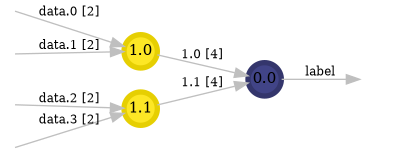

In [7]:
DEVICE = 'cuda'
DTYPE = torch.double
N_FEAT = 4
ttn = TTN(N_FEAT, bond_dim=8, n_labels=2, device=DEVICE, dtype=DTYPE)
ttn.draw()

### Basic operations
General purpose contraction, not optimized

In [8]:
def contract(
        tensors : Sequence[torch.Tensor] | ValuesView[torch.Tensor], 
        tindices: Sequence[TTNIndex | TIndex], 
        keep    : Sequence[str] | None=None, 
        outname : str | None=None
):
    """
    Contract two tensors along the matching TIndices in indices, except for the indices in keep.
    """
    if len(tindices) != len(tensors):
        raise ValueError(f"Expected tensors and tindices to have same lenght, got {len(tensors)} and {len(tindices)}")

    if keep is None:
        keep = []
    elif isinstance(keep, str):
        keep = [keep]
    elif not isinstance(keep, Sequence):
        raise TypeError(f"Expected keep to be None, str or Sequence, got {type(keep)}")

    keep = list(keep)
    unique_inds, counts = np.unique(np.concatenate([tindex.indices for tindex in tindices]), return_counts=True)
    if np.any(np.isin(keep, unique_inds, invert=True)):
        raise ValueError(f"keep contains indices that are not in tindices: {np.asarray(keep)[np.where(np.isin(keep, unique_inds, invert=True))[0]]}")
    if len(unique_inds) > len(ascii_letters):
        raise ValueError(f"Too many indices to contract: {len(unique_inds)} > {len(ascii_letters)}")

    # find output indices (all indices that are not contracted or kept)
    output_inds = unique_inds[np.isin(unique_inds, keep) | (counts == 1)]
    
    # map indices to letters
    idx_to_char_map = {tind: ascii_letters[i] for i, tind in enumerate(unique_inds)}
    
    # contraction strings
    ## tensor indices
    tindices_str = ["..."+"".join([idx_to_char_map[i] for i in tindex.indices]) for tindex in tindices] # the ellipsis is for batch dimension
    ## output indices
    outinds_str = "..."+"".join([idx_to_char_map[i] for i in output_inds])

    #print(tindices_str,'\n' ,outinds_str)
    # contract
    C = torch.einsum(f"{','.join(tindices_str)}->{outinds_str}", *tensors)

    return C, TIndex(f"{min(tindices)}" if outname is None else outname, output_inds)

    

Let's exploit the TTN topology to optimize contractions, i.e. make them go from bottom to top

In [9]:
def contract_up(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector
    
    left = torch.matmul(data_tensors[0], tensor.view(tensor.shape[0], -1))              # left contraction with data (b x p) @ (p x d) -> (b x d) where d is m*n
    right = torch.bmm(data_tensors[1].unsqueeze(1), left.view(-1, *tensor.shape[1:]))   # right contraction with data (b x 1 x m) @ (b x m x n) -> (b x n) 

    return right.view(-1, tensor.shape[2])

def contract_up_einsum(tensor: torch.Tensor, data_tensors: Sequence[torch.Tensor]):
    # this function is the fundamental block for TTN contractions:
    # it takes a ttn tensor and two data vectors and contracts them to a new vector

    return torch.einsum('bi,ijk,bj->bk', data_tensors[0], tensor, data_tensors[1])

### Tests

In [9]:
data = torch.rand(N_FEAT, 10, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"{ttn.n_layers}.{i}", [f"data.{i}"]) for i in range(N_FEAT)]

time1 = timeit(lambda: contract_up(ttn.tensors[-1], data[:2]), number=10000)
time2 = timeit(lambda: contract((ttn.tensors[-1],) + data[:2], [ttn.indices[-1]]+data_indices[:2]), number=10000)
time3 = timeit(lambda: contract_up_einsum(ttn.tensors[-1], data[:2]), number=10000)
time1, time2, time3

(0.5259975589999613, 4.228730344000041, 2.064537687999973)

In [10]:
data = torch.rand(N_FEAT, 64, 2, dtype=DTYPE, device=DEVICE).unbind(0)
data_indices = [TIndex(f"data.{i}", [f"data.{i}"]) for i in range(N_FEAT)]
i=1
time1 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0')), number=100)
time2 = timeit(lambda: ttn._propagate_data_through_branch_(dict(zip(data_indices, data)), ttn.get_branch('1.0'), keep=True), number=100)
time3 = timeit(lambda: contract(list(ttn.get_branch(f'1.{i}').values()) + list(data[16*i:16*(i+1)]), list(ttn.get_branch(f'1.{i}').keys())+data_indices[16*i:16*(i+1)]), number=100)
print(time1, time2, time3)

0.15332410799965146 0.12349873000130174 2.825117341002624


TEST the contraction scheme by a synthetic dataset and the TTN initialized to identities

In [10]:
def generate_i_state(n_sites, i, dtype=torch.double):
    """
    Generates a separable state wich would be represented 
    as a vector with 1 at i-th position in the full form.
    """
    sites = []
    bin_str = f'{i:b}'
    bin_str = '0'*(n_sites-len(bin_str)) + bin_str
    for char in bin_str:
        if char == '0':
            sites.append(torch.as_tensor([1.0, 0.0], dtype=dtype))
        else:
            sites.append(torch.as_tensor([0.0, 1.0], dtype=dtype))
 
    state = torch.stack(sites)

    return state


# create general purpose identity tensor
# this is a 3d tensor with 1 on the diagonal
ID = torch.zeros([4, 4, 4], dtype=DTYPE)
for i in range(ID.shape[0]):
    ID[i, i, i] = 1.0
# create data
# you can choose from different states
I = 0 # position of 1 in the resulting state (starting from 0)
test_states = {'up': [1, 0], 'down': [0, 1], 'plus': [1/(2**0.5), 1/(2**0.5)], 'minus': [1/(2**0.5), -1/(2**0.5)], 'i': generate_i_state(N_FEAT, I)}
data = torch.expand_copy(torch.as_tensor(test_states['i'], dtype=DTYPE), [64, N_FEAT, 2])

# transform to data dictionary to pass to _propagate_data_through_branch_
data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(data.unbind(1))}
# set TTN tensors to identity
ttn.tensors = [torch.eye(tensor.shape[0]**2, dtype=DTYPE).reshape(*tensor.shape[:2], -1)[:,:,:tensor.shape[-1]] for tensor in ttn.tensors] #[ID[:tensor.shape[0], :tensor.shape[1], :tensor.shape[2]] for tensor in ttn.tensors]
# contract
pbar = tqdm(total=len(ttn.tensors), desc='ttn test', position=0)
result = ttn._propagate_data_through_branch_(data_dict, ttn.get_branch('0.0'), keep=True, pbar=pbar)['0.0']
pbar.close()
result[0]

ttn test: 100%|██████████| 3/3 [00:00<00:00, 255.05it/s, contracted 0.0] 


tensor([1., 0.], dtype=torch.float64)

## Torch Model

In [9]:

class TTNModel(torch.nn.Module, TTN):
    def __init__(
            self,
            n_features,
            n_phys=2,
            n_labels=2,
            label_tag="label",
            bond_dim=8,
            dtype=torch.cdouble,
            device="cpu"
    ):
        torch.nn.Module.__init__(self)
        TTN.__init__(self, n_features, n_phys, n_labels, label_tag, bond_dim, dtype, device)

    def initialize(self, dm_init=False, train_dl: torch.utils.data.Dataloader = None, loss_fn = None, epochs=5, disable_pbar=False):
        if dm_init:
            if (train_dl is None) or (loss_fn is None):
                raise ValueError(f"The unsupervised and supervised initialization were invoked but the dataloader was: {train_dl}\n and the loss function was: {loss_fn}")
            else:
                TTN.initialize(self, train_dl, loss_fn, epochs, disable_pbar=disable_pbar)
        
        super(TTNModel, type(self)).tensors.fset(self, torch.nn.ParameterList([torch.nn.Parameter(t, requires_grad=True) for t in self.tensors]))
        self.model_init = True

    def draw(self):
        return TTN.draw(self)

    def forward_old(self, x: torch.Tensor):
        if not self.initialized:
            raise RuntimeError("TTNModel not initialized")
        data = x.unbind(0)
        data_indices = tuple([TIndex(f"{self.n_layers}.{i}", [f"data.{i}"]) for i in range(len(data))])
    
        # propagate data (max 4 layers at once)
        skip = 2
        for i in range(self.n_layers, 0, -skip):
            layer = i-skip if i > skip else 0
            print('propagating', layer, i)
            propagated = [contract(tuple(self.get_branch(f'{layer}.{j}', till=f'{i if i!=self.n_layers else "data"}').values()) + data[2**(i-1)*j:2*(i-1)*(j+1)], 
                                   tuple(self.get_branch(f'{layer}.{j}', till=f'{i if i!=self.n_layers else "data"}').keys()) + data_indices[2**(i-1)*j:2*(i-1)*(j+1)]) for j in range(2**layer)]
            data, data_indices = zip(*propagated)
            print('done', i, type(data), type(data_indices))

        return data[0]
    
    def forward(self, x: torch.Tensor):
        if not self.model_init:
            raise RuntimeError("TTNModel not initialized")
        data_dict = {TIndex(f"data.{i}", [f"data.{i}"]): datum for i, datum in enumerate(x.unbind(1))}

        return self._propagate_data_through_branch_(data_dict, self.get_branch('0.0'), keep=True)['0.0']


# Test the model

In [10]:
h = 4
BATCH_SIZE = 8
DATASET = 'iris'

if DATASET == 'mnist':
    train_dl, test_dl, train_visual = get_mnist_data_loaders(h, batch_size=BATCH_SIZE)
elif DATASET == 'stripe':
    train_dl, test_dl = get_stripeimage_data_loaders(h, batch_size=BATCH_SIZE)
elif DATASET == 'iris':
    # worst performance with iris-versicolor and iris-virginica
    train_dl, test_dl, h = get_iris_data_loaders(batch_size=BATCH_SIZE, labels=['Iris-virginica', 'Iris-versicolor'])

In [11]:
def loss(labels, output):
    return torch.mean((output.squeeze() - labels)**2)/2

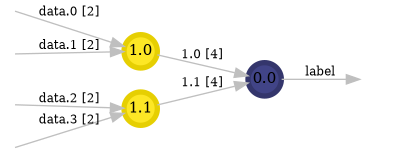

In [12]:
DEVICE = 'cuda'
BOND_DIM = 4
DTYPE = torch.double
features = h**2

model = TTNModel(features, bond_dim=BOND_DIM, n_labels=1, device=DEVICE, dtype=DTYPE)
model.draw()

In [13]:
INIT_EPOCHS = 3

model.initialize(True, train_dl, loss, INIT_EPOCHS)

ttn supervised init:   0%|          | 0/10 [00:01<?, ?it/s, doing epoch 3/3]


In [14]:
print(check_correct_init(model))
summary(model, input_size=(BATCH_SIZE, features, 2), dtypes=[DTYPE], device=DEVICE)

(True, 0)


Layer (type:depth-idx)                   Output Shape              Param #
TTNModel                                 [8, 1]                    48
Total params: 48
Trainable params: 48
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [17]:
data = torch.rand(256, features, 2, dtype=DTYPE, device=DEVICE)
with torch.no_grad():
    result = timeit(lambda: model(data), number=1000)
result

0.26698722499997984

In [15]:

def train_one_epoch(model, device, train_dl, loss_fn, optimizer, pbar=None, disable_pbar=False):
    running_loss = 0.
    last_loss = 0.
    last_batch = 0
    loss_history = []
    close_pbar = False
    if pbar is None:
        close_pbar = True
        pbar = tqdm(enumerate(train_dl), total=len(train_dl),position=0, leave=True, disable=disable_pbar)
    for i, data in enumerate(train_dl):

        # Every data instance is an input + label pair
        inputs, labels = data
        inputs, labels = inputs.squeeze().to(device, dtype=DTYPE, non_blocking=True), labels.to(device)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Make predictions for this batch
        outputs = model(inputs)
        probs = torch.pow(outputs, 2)
        if DTYPE == torch.cdouble:
            probs = torch.real(probs)

        #probs = probs / torch.sum(probs, -1)
        
        # Compute the loss and its gradients
        loss = loss_fn(labels, probs)
        loss.backward()
        
        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        loss_history.append(loss.item())
        if i % 10 == 9:
            last_batch = i+1
            last_loss = running_loss / 10 # mean loss over 10 batches
            running_loss = 0.  
        pbar.update()
        pbar.set_postfix({'current loss': loss.item(), 
                          f'batches {last_batch-10}-{last_batch} loss': last_loss, 
                          'weight_norm': torch.as_tensor([torch.norm(tensor) for tensor in model.tensors]).mean(0).item()})
        
    pbar.set_postfix({'current loss': loss.item(), f'batches {last_batch-10}-{last_batch} loss': last_loss, 'epoch mean loss': np.array(loss_history).mean()}) # not correct as the last batch is averaged on less samples
    if close_pbar:
        pbar.close()
    return loss_history


In [16]:
LR = 0.02
EPOCHS = 80
SCHEDULER_STEPS = 4


model.train()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
scheduler = schedulers[0]

In [17]:

tot_loss_history = []
now = datetime.now()
for epoch in trange(EPOCHS, desc='epochs', position=0):
    loss_history = train_one_epoch(model, DEVICE, train_dl, loss, optimizer)
    tot_loss_history += loss_history
    if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
        scheduler.step()

    
loss_history = np.array(tot_loss_history)

epochs: 100%|██████████| 80/80 [00:24<00:00,  3.33it/s]


In [45]:
scheduler.get_last_lr()

[0.001215766545905694]

In [18]:
def accuracy(model, device, train_dl, test_dl, dtype=torch.complex128, disable_pbar=False):
    correct = 0
    total = 0

    model.eval()
    model.to(device)

    with torch.no_grad():
        for data in tqdm(test_dl, total=len(test_dl), position=0, desc='test', disable=disable_pbar):
            images, labels = data
            images, labels = images.to(device, dtype=dtype).squeeze(), labels.to(device)
            outputs = model(images)
            probs = torch.real(torch.pow(outputs, 2))
            #probs = probs / torch.sum(probs)
            predicted = torch.round(probs.squeeze().data)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_accuracy = correct / total

        correct = 0
        total = 0

        for data in tqdm(train_dl, total=len(train_dl), position=0, desc='train', disable=disable_pbar):
            images, labels = data
            images, labels = images.to(device, dtype=dtype).squeeze(), labels.to(device)
            outputs = model(images)
            probs = torch.real(torch.pow(outputs, 2))
            #probs = probs / torch.sum(probs)
            predicted = torch.round(probs.squeeze().data)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        train_accuracy = correct / total

    return train_accuracy, test_accuracy


In [19]:
accuracy(model, DEVICE, train_dl, test_dl, DTYPE)

train: 100%|██████████| 10/10 [00:00<00:00, 76.92it/s]


(0.95, 1.0)

In [20]:
torch.save(model.state_dict, f'models/trainedmodel_{DATASET}_bond{BOND_DIM}_type{str(DTYPE).split(".")[1]}_{now.strftime("%Y%m%d-%H%M%S")}.dict')
np.save(f'models/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.npy', loss_history)

0.019087757237865495


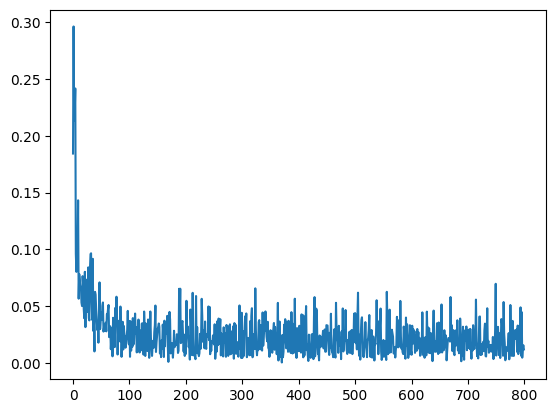

In [21]:
plt.plot(range(len(loss_history)), loss_history)
#plt.ylim(0, 2)
print(np.mean(loss_history[-10:]))

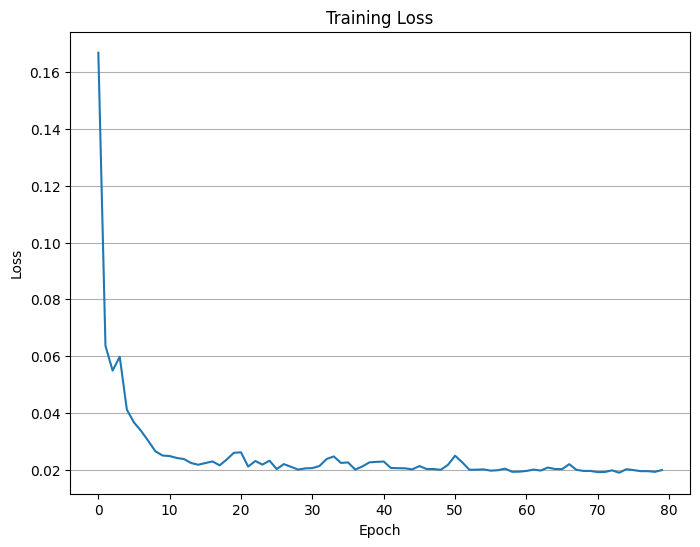

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.plot([loss_history[i*len(train_dl):((i+1)*len(train_dl) if i<EPOCHS-1 else -1)].mean() for i in range(EPOCHS)])
#ax.set_ylim(0, 0.3)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
ax.grid(axis='y')

fig.savefig(f'models/loss_history_{now.strftime("%Y%m%d-%H%M%S")}.png')

In [23]:
def get_predictions(model, device, dl, dtype=torch.complex128, disable_pbar=False):

    model.eval()
    model.to(device)
    predictions = []
    with torch.no_grad():
        for data in tqdm(dl, total=len(dl), position=0, desc='test', disable=disable_pbar):
            images, labels = data
            images, labels = images.to(device, dtype=dtype).squeeze(), labels.to(device)
            outputs = model(images)
            probs = torch.real(torch.pow(outputs, 2))
            #probs = probs / torch.sum(probs)
            predictions.append(probs.squeeze().detach().cpu())

    return torch.concat(predictions, dim=0)


test: 100%|██████████| 3/3 [00:00<00:00, 631.36it/s]


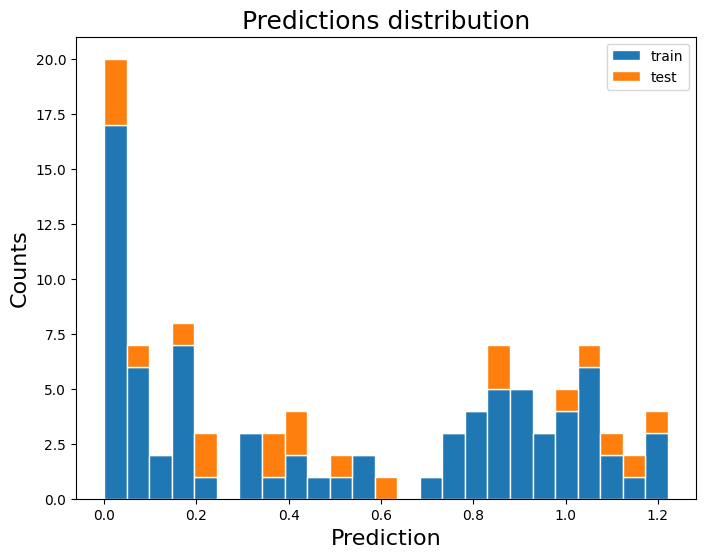

In [24]:
train_pred = get_predictions(model, DEVICE, train_dl, DTYPE)
test_pred = get_predictions(model, DEVICE, test_dl, DTYPE)
FS=16
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.hist([train_pred, test_pred], bins=25, label=['train', 'test'], stacked=True, edgecolor='white')
ax.legend()
ax.set_xlabel('Prediction', fontsize=FS)
ax.set_ylabel('Counts', fontsize=FS)
ax.set_title('Predictions distribution', fontsize=FS+2)

fig.savefig(f'models/predictions_dist_{now.strftime("%Y%m%d-%H%M%S")}.png')

In [25]:
#save model weights
np.savez(f'models/weights_{now.strftime("%Y%m%d-%H%M%S")}.npz', **{key.name : value.cpu().detach() for key, value in model._TTN__tensor_map.items()})

In [26]:
np.load(f'models/weights_{now.strftime("%Y%m%d-%H%M%S")}.npz', allow_pickle=True)['0.0']

array([[[ 0.92676304],
        [ 0.16776162],
        [-0.34247022],
        [ 0.91754829]],

       [[-0.29305835],
        [ 0.11300487],
        [-0.11165282],
        [ 0.07450146]],

       [[ 0.12491639],
        [ 0.5886701 ],
        [ 0.63739822],
        [ 0.20972033]],

       [[ 0.51550485],
        [ 0.02084619],
        [-0.47648278],
        [ 0.22286643]]])

In [30]:
import pandas as pd
from utils import quantize
dataframe = pd.read_csv('../data' + '/iris/Iris.csv')
labels = ['Iris-virginica', 'Iris-versicolor']

#dataframe = dataframe.sample(frac=1).reset_index(drop=True)

dataframe['SepalLengthCm'] = dataframe['SepalLengthCm'] / dataframe['SepalLengthCm'].max()
dataframe['SepalWidthCm'] = dataframe['SepalWidthCm'] / dataframe['SepalWidthCm'].max()
dataframe['PetalLengthCm'] = dataframe['PetalLengthCm'] / dataframe['PetalLengthCm'].max()
dataframe['PetalWidthCm'] = dataframe['PetalWidthCm'] / dataframe['PetalWidthCm'].max()
dataframe = dataframe[dataframe['Species'].isin(labels)]
labels = dataframe['Species'].to_numpy()
labels = np.where(labels == labels[0], 0, 1)
#labels = torch.tensor(labels)


data = dataframe.drop(columns=['Id', 'Species']).to_numpy()
data = torch.tensor(data)
train_size = int(0.8 * len(data))
data = quantize(data)
np.save('../data/iris/iris_embedded.npy', data.numpy())

In [79]:
np.load('../data/iris/iris_embedded.npy').shape

(100, 4, 2)

In [24]:
import pandas as pd

dataframe = pd.DataFrame(columns=['feat', 'bond_dim', 'train_acc', 'test_acc', 'loss', 'time', 'date'])

In [25]:
dataframe[0] = [64, 32, 0.95, 0.9, 0.1, 10, 25]

In [27]:
series = pd.Series(name='feat')
series[0] = 64
series[1] = 32
series

0    64
1    32
Name: feat, dtype: int64

In [33]:
series2 = pd.Series(name='bond_dim')
series2[0] = 32
series2[1] = 16

In [38]:
df = pd.DataFrame()
df['feat'] = series
df['bond_dim'] = series2
df

,feat,bond_dim
0,64,32
1,32,16


In [40]:
df.to_numpy()

array([[64, 32],
       [32, 16]])

In [39]:
pd.Series(name='feat', data=[64, 32])

0    64
1    32
Name: feat, dtype: int64

In [3]:
dataframe

,feat,bond_dim,train_acc,test_acc,loss,time,date,0
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7


## Get weights distribution

In [36]:
def get_weights_population(n, disable_pbar=False):
    weights_ls = []
    DEVICE = 'cuda'
    BOND_DIM = 4
    DTYPE = torch.double
    INIT_EPOCHS = 5
    LR = 0.05
    EPOCHS = 80
    SCHEDULER_STEPS = 4
    train_dl, test_dl, h = get_iris_data_loaders(batch_size=BATCH_SIZE, labels=['Iris-virginica', 'Iris-versicolor'])
    features = h**2
    pbar = tqdm(total=n*EPOCHS*len(train_dl), position=0, desc='weights population', leave=True, disable=disable_pbar)
    for _ in range(n):        
        model = TTNModel(features, bond_dim=BOND_DIM, n_labels=1, device=DEVICE, dtype=DTYPE)
        model.initialize(True, train_dl, loss, INIT_EPOCHS, disable_pbar=True)
        model.train()
        model.to(DEVICE)
        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
        schedulers = [torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.9, last_epoch=-1, verbose=False), torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 10, eta_min=1e-5)]
        scheduler = schedulers[0]
        tot_loss_history = []
        for epoch in range(EPOCHS):
            loss_history = train_one_epoch(model, DEVICE, train_dl, loss, optimizer, pbar=pbar, disable_pbar=disable_pbar)
            tot_loss_history += loss_history
            if epoch % SCHEDULER_STEPS == SCHEDULER_STEPS-1:
                scheduler.step()

        loss_history = np.array(tot_loss_history)
        print('Accuracy on train and test set:', accuracy(model, DEVICE, train_dl, test_dl, DTYPE, disable_pbar=True))

        weights = [tensor.detach().cpu().flatten() for tensor in model.tensors]
        weights_ls.append(torch.concat(weights, dim=0))
        train_dl, test_dl, h = get_iris_data_loaders(batch_size=BATCH_SIZE, labels=['Iris-virginica', 'Iris-versicolor'])
    return torch.stack(weights_ls)

In [37]:
weights = get_weights_population(10)

weights population:  10%|█         | 800/8000 [00:15<02:04, 58.02it/s, current loss=0.0255, batches 0-10 loss=0.0132, epoch mean loss=0.0132] 

Accuracy on train and test set: (0.9875, 0.9)


weights population:  20%|██        | 1600/8000 [00:31<01:55, 55.29it/s, current loss=0.00784, batches 0-10 loss=0.018, epoch mean loss=0.018]  

Accuracy on train and test set: (0.975, 1.0)


weights population:  30%|███       | 2400/8000 [00:47<01:38, 56.96it/s, current loss=0.0503, batches 0-10 loss=0.0183, epoch mean loss=0.0183] 

Accuracy on train and test set: (0.975, 1.0)


weights population:  40%|████      | 3200/8000 [01:03<01:30, 53.21it/s, current loss=0.0124, batches 0-10 loss=0.0162, epoch mean loss=0.0162] 

Accuracy on train and test set: (0.975, 0.95)


weights population:  50%|█████     | 4000/8000 [01:19<01:11, 55.59it/s, current loss=0.00404, batches 0-10 loss=0.0239, epoch mean loss=0.0239]

Accuracy on train and test set: (0.925, 1.0)


weights population:  60%|██████    | 4800/8000 [01:36<00:59, 53.56it/s, current loss=0.0451, batches 0-10 loss=0.0246, epoch mean loss=0.0246] 

Accuracy on train and test set: (0.95, 1.0)


weights population:  70%|███████   | 5600/8000 [01:52<00:45, 53.18it/s, current loss=0.0511, batches 0-10 loss=0.0267, epoch mean loss=0.0267] 

Accuracy on train and test set: (0.9375, 0.95)


weights population:  80%|████████  | 6400/8000 [02:09<00:28, 55.74it/s, current loss=0.00423, batches 0-10 loss=0.0132, epoch mean loss=0.0132]

Accuracy on train and test set: (1.0, 0.9)


weights population:  90%|█████████ | 7200/8000 [02:26<00:15, 51.75it/s, current loss=0.0233, batches 0-10 loss=0.0227, epoch mean loss=0.0227] 

Accuracy on train and test set: (0.9625, 0.95)


weights population: 100%|██████████| 8000/8000 [02:43<00:00, 48.85it/s, current loss=0.0542, batches 0-10 loss=0.0246, epoch mean loss=0.0246] 


Accuracy on train and test set: (0.95, 1.0)


/tmp/ipykernel_25558/1862781791.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticks(), fontsize=FS-2)
/tmp/ipykernel_25558/1862781791.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks(), fontsize=FS-2)


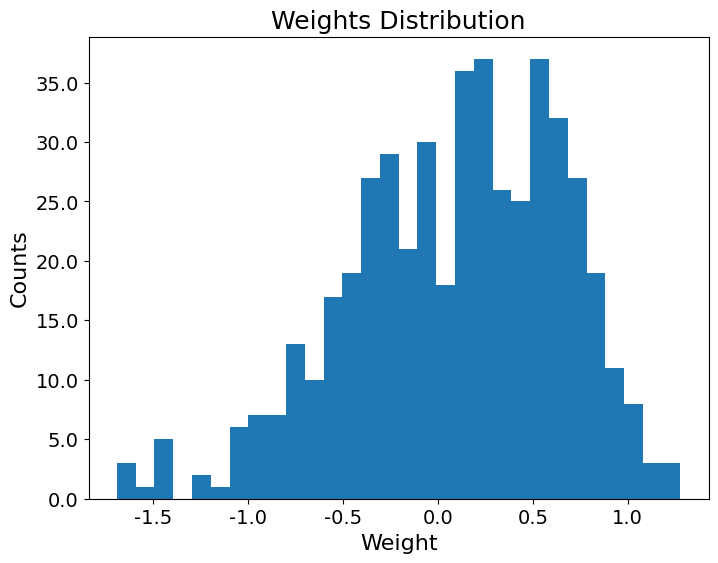

In [42]:
weights_plt = weights.flatten().numpy()
np.save(f'models/weights_{now.strftime("%Y%m%d-%H%M%S")}.npy', weights.numpy())
FS = 16
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.hist(weights_plt, bins=30)
ax.set_xlabel('Weight', fontsize=FS)
ax.set_ylabel('Counts', fontsize=FS)
ax.set_title('Weights Distribution', fontsize=FS+2)
ax.set_xticklabels(ax.get_xticks(), fontsize=FS-2)
ax.set_yticklabels(ax.get_yticks(), fontsize=FS-2)

fig.savefig(f'models/weight_distribution_{now.strftime("%Y%m%d-%H%M%S")}.svg')

In [43]:
print('min', np.abs(weights.numpy()).min(), 'max', np.abs(weights.numpy()).max(), sep='\n')

min
0.003625212507411981
max
1.6900352563812266
